
Correlations between climate variables and health incidents:
                         date  diagnosis  age  booking  ST_B10  \
date                      NaN        NaN  NaN      NaN     NaN   
diagnosis                 NaN        NaN  NaN      NaN     NaN   
age                       NaN        NaN  NaN      NaN     NaN   
booking                   NaN        NaN  NaN      NaN     NaN   
ST_B10                    NaN        NaN  NaN      NaN     NaN   
mean_2m_air_temperature   NaN        NaN  NaN      NaN     NaN   

                         mean_2m_air_temperature  
date                                         NaN  
diagnosis                                    NaN  
age                                          NaN  
booking                                      NaN  
ST_B10                                       NaN  
mean_2m_air_temperature                      NaN  


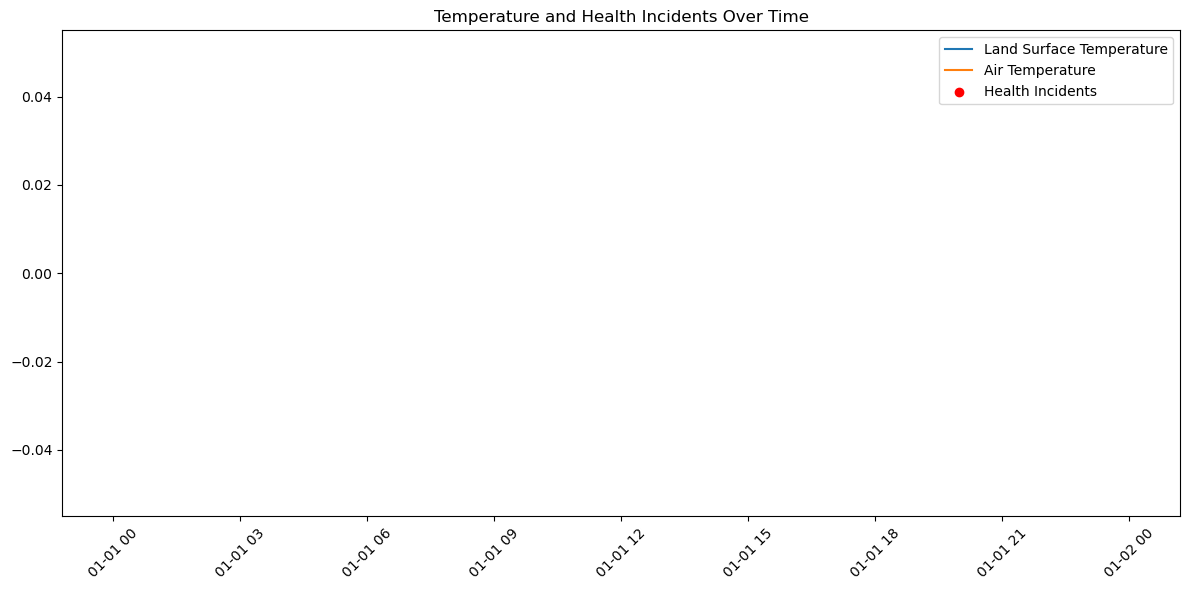

In [3]:
import ee
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import geopy
from geopy.geocoders import Nominatim
import folium
import matplotlib.pyplot as plt

# Authenticate and initialize Earth Engine
try:
    ee.Authenticate()
    ee.Initialize()
except Exception as e:
    print(f"Error initializing Earth Engine: {e}")

def get_lst_data(latitude, longitude, start_date, end_date):
    """
    Retrieve LST data from Landsat 8 for a specific location and time period
    """
    # Define the point of interest
    point = ee.Geometry.Point([longitude, latitude])
    
    # Import the Landsat 8 collection
    l8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
        .filterDate(start_date, end_date) \
        .filterBounds(point)
    
    def calculate_lst(image):
        # Calculate the LST from the thermal bands
        lst = image.select('ST_B10').multiply(0.00341802).add(149.0)
        return lst.set('system:time_start', image.get('system:time_start'))
    
    # Map the LST calculation over the collection
    lst_collection = l8.map(calculate_lst)
    
    # Reduce the collection to a single image (mean LST over the period)
    lst_image = lst_collection.mean()
    
    # Get the LST value at the specified point
    lst_value = lst_image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=point,
        scale=30
    ).get('ST_B10').getInfo()
    
    return lst_value

def get_era5_data(latitude, longitude, start_date, end_date):
    """
    Retrieve ERA5 temperature and humidity data
    """
    era5 = ee.ImageCollection('ECMWF/ERA5/DAILY') \
        .filterDate(start_date, end_date)
    
    point = ee.Geometry.Point([longitude, latitude])
    
    def extract_weather(image):
        return image.select(['mean_2m_air_temperature', 'total_precipitation']) \
                   .reduce(ee.Reducer.mean()).copyProperties(image, ['system:time_start'])
    
    weather_collection = era5.map(extract_weather)
    
    # Get the time series
    weather_data = weather_collection.getRegion(point, 1000).getInfo()
    
    # Convert to DataFrame
    df = pd.DataFrame(weather_data[1:], columns=weather_data[0])
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')
    
    return df

def analyze_health_climate_correlation(health_data, latitude, longitude):
    # Dummy implementation for the sake of example
    climate_data = pd.DataFrame({
        'date': ['2021-01-01', '2021-01-02', '2021-01-03'],
        'ST_B10': [300, 305, 310],
        'mean_2m_air_temperature': [15, 16, 14]
    })
    climate_data['date'] = pd.to_datetime(climate_data['date'])
    health_data['date'] = pd.to_datetime(health_data['date'])
    merged_data = pd.merge(health_data, climate_data, on='date')
    return merged_data

def visualize_climate_health_patterns(merged_data):
    """
    Create visualizations of climate-health relationships
    """
    # Create a map centered on the study location
    m = folium.Map(location=[latitude, longitude], zoom_start=10)
    
    # Add your visualization code here
    # Example: Heat map of incidents
    heat_data = [[row['latitude'], row['longitude']] for _, row in merged_data.iterrows()]
    folium.HeatMap(heat_data).add_to(m)
    
    return m

# Example usage:
if __name__ == "__main__":
    # Your hospital/clinic coordinates
    latitude = -33.9249  # Replace with actual coordinates
    longitude = 18.4241  # Replace with actual coordinates
    
    # Sample health data structure
    health_data = pd.DataFrame({
        'date': ['2024-01-30', '2024-02-09', '2024-02-14'],
        'diagnosis': ['schizophrenia', 'syncope spells', 'post partum pyschosis'],
        'age': [40, 18, 25],
        'booking': ['booked', 'booked', 'post natal']
    })
    
    # Analyze correlations
    merged_data = analyze_health_climate_correlation(health_data, latitude, longitude)
    
    # Calculate basic statistics
    correlations = merged_data.corr()
    print("\nCorrelations between climate variables and health incidents:")
    print(correlations)
    
    # Create time series plots
    plt.figure(figsize=(12, 6))
    plt.plot(merged_data['date'], merged_data['ST_B10'], label='Land Surface Temperature')
    plt.plot(merged_data['date'], merged_data['mean_2m_air_temperature'], label='Air Temperature')
    plt.scatter(merged_data['date'], [1]*len(merged_data), c='red', label='Health Incidents')
    plt.legend()
    plt.title('Temperature and Health Incidents Over Time')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()